In [1]:
import glob
import os
from random import shuffle
# from nltk.tokenize import TreebankWordTokenizer
# from gensim.models.keyedvectors import KeyedVectors
import numpy as np
from tensorflow import keras
# word_vector=KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin',binary=True)

def pre_process_data(filepath):
    positive_path=os.path.join(filepath,'pos')
    negative_path=os.path.join(filepath,'neg')
    pos_label=1
    neg_label=0
    dataset=[]
    for filename in glob.glob(os.path.join(positive_path,'*.txt')):
        dataset.append((pos_label,filename))
    for filename in glob.glob(os.path.join(negative_path,'*.txt')):
        dataset.append((neg_label,filename))
    shuffle(dataset)
    return dataset

dataset=pre_process_data('data/aclImdb/train')
split_point=int(len(dataset)*0.8)
trainData=dataset[:split_point]
testData=dataset[split_point:]
tokenizer=TreebankWordTokenizer()


trainlen=len(trainData)
testlen=len(testData)

maxlen=206
batch_size=32
embedding_dims=300
epochs=10
dataset[:5]

[(0, 'data/aclImdb/train/neg/11199_1.txt'),
 (0, 'data/aclImdb/train/neg/2814_3.txt'),
 (1, 'data/aclImdb/train/pos/11330_8.txt'),
 (1, 'data/aclImdb/train/pos/2925_10.txt'),
 (0, 'data/aclImdb/train/neg/7716_4.txt')]

In [2]:
def avg_len(data):
    total_len=0
    for sample in data:
        with open(sample[1],'r') as f:
            total_len+=len(f.read())
    return total_len/len(data)
avg_len(dataset)

1325.06964

507


In [4]:
def clean_data(data): #加载数据文件，变成字符数组，一下加载所有的文件
    new_data=[]
    VALID='abcdefghijklmnopqrstuvwxyz0123456789"\'?!.,:;`~@#$%^&*()_-+=/><[]{} \\'
    for sample in data:
        with open(sample[1],'r') as f:
            fcontent=f.read()
            new_sample=[]
            for charc in fcontent.lower():
                if charc in VALID:
                    new_sample.append(charc)
                else:
                    new_sample.append('UNK')
            new_data.append(new_sample)
    return new_data

def clean_data_ger(filename): #转变成单一文件为一个字符数组
    VALID='abcdefghijklmnopqrstuvwxyz0123456789"\'?!.,:;`~@#$%^&*()_-+=/><[]{} \\'
    with open(filename,'r') as f:
        sample=f.read()
    new_sample=[]
    for charc in sample.lower():
        if charc in VALID:
            new_sample.append(charc)
        else:
            new_sample.append('UNK')
    return new_sample


In [5]:
def char_pad_trunc(data,maxlen=1500): #讲字符数组标准化长度，不足长度后面补PAD
    new_dataset=[]
    for sample in data:
        if len(sample)>maxlen:
            new_data=sample[:maxlen]
        elif len(sample)<maxlen:
            pads=maxlen-len(sample)
            new_data=sample+['PAD']*pads
        else:
            new_data=sample
        new_dataset.append(new_data)
    return new_dataset

def char_pad_trunc_ger(data,maxlen=1500): #
    if len(data)>maxlen:
        new_data=data[:maxlen]
    elif len(data)<maxlen:
        pads=maxlen-len(data)
        new_data=data+['PAD']*pads
    else:
        new_data=data
    return new_data

In [6]:
def create_dicts(data):
    chars=set()
    for sample in data:
        chars.update(set(sample))
    char_indices=dict((c,i) for i,c in enumerate(chars))
    indices_char=dict((i,c) for i,c in enumerate(chars))
    return char_indices,indices_char

In [7]:
import numpy as np
def onehot_encode(dataset,char_indices,maxlen=1500):
    X=np.zeros((len(dataset),maxlen,len(char_indices.keys())))
    for i,sentence in enumerate(dataset):
        for t,char in enumerate(sentence):
            X[i,t,char_indices[char]]=1
    return X
def onehot_encode_ger(sentence,char_indices,maxlen=1500):
    X=np.zeros((maxlen,len(char_indices.keys())))
    for t,char in enumerate(sentence):
        X[t,char_indices[char]]=1
    return X

In [8]:
def data_generator(datastore,char_indices,batchsize=32,maxlen=1500):
    X,Y=[],[]
    while True:
        for i in range(len(datastore)):
            if (i % batchsize==0 and X and Y) or (i==len(datastore)):
                X=np.reshape(X,(len(X),maxlen,len(char_indices)))
                Y=np.array(Y)
                yield X,Y
                X,Y=[],[]
            x,y=datastore[i][1],datastore[i][0]
            x=onehot_encode_ger(char_pad_trunc_ger(clean_data_ger(x),maxlen=maxlen),char_indices,maxlen=maxlen)   
            X.append(x)
            Y.append(y)

In [21]:
lsitified_data=clean_data(dataset)
common_length_data=char_pad_trunc(lsitified_data,maxlen=1500)
char_indices,indices_char=create_dicts(common_length_data) #生成字符和序号映射，也就是字符字典
# char_indices,indices_char=create_dicts(dataset)

In [23]:
#验证一下两者生成是不是相同
ss1=onehot_encode_ger(common_length_data[0],char_indices,maxlen=1500)
ss=onehot_encode_ger(char_pad_trunc_ger(clean_data_ger(dataset[0][1]),maxlen=1500),char_indices,maxlen=1500)
dataset[0][1]


In [24]:
np.set_printoptions(suppress = True)
np.sum(ss1,axis=0)

array([ 41.,   0.,   7.,   8.,   0.,   0.,   0.,  50.,   1.,   0.,   0.,
         0.,  25.,   0.,   0.,   0.,   0.,   5.,   8.,   0.,   0.,  25.,
        13.,   2.,   0.,  14.,   0.,   0.,   0.,   0.,   0.,   0.,  48.,
         0.,   0.,   0.,  19.,   0.,   0.,   0.,   0.,   0.,  25.,   0.,
         8.,  10.,   0.,  35.,   3.,   0.,  12.,   0.,   1.,   7.,   0.,
         7., 993.,   2.,   0.,   0.,  12.,   0.,  90.,  20.,   9.,   0.,
         0.,   0.,   0.,   0.])

In [27]:
np.sum(ss,axis=0)


array([ 41.,   0.,   7.,   8.,   0.,   0.,   0.,  50.,   1.,   0.,   0.,
         0.,  25.,   0.,   0.,   0.,   0.,   5.,   8.,   0.,   0.,  25.,
        13.,   2.,   0.,  14.,   0.,   0.,   0.,   0.,   0.,   0.,  48.,
         0.,   0.,   0.,  19.,   0.,   0.,   0.,   0.,   0.,  25.,   0.,
         8.,  10.,   0.,  35.,   3.,   0.,  12.,   0.,   1.,   7.,   0.,
         7., 993.,   2.,   0.,   0.,  12.,   0.,  90.,  20.,   9.,   0.,
         0.,   0.,   0.,   0.])

In [29]:
with open(dataset[0][1],'r') as f:
    print(f.read())

The turgid pace of this movie numbs us to any shocks that it might provide. There was no real suspense. Most of the characters were insipid. The chesty Irish priest was as lame as the love interest. Interest is misleading. The girl that they chose to provide the film's sensuality might be better. The central conflict of the main character was uninvolving. This film is entirely devoid of positives. \like\ It is like a tedious exercise by someone who didn't want to go to the gym that day but did anyway.



In [31]:
np.array(common_length_data[0]) #可以直接显示common_length_data[0],会竖着显示，很讨厌，验证的时候可以自己更改

array(['t', 'h', 'e', ..., 'PAD', 'PAD', 'PAD'], dtype='<U3')

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Embedding,Flatten,LSTM
num_neurons=40
maxlen=1500
model=Sequential()
model.add(LSTM(num_neurons,return_sequences=True,input_shape=(maxlen,len(char_indices.keys()))))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop',metrics=['accuracy'],loss='binary_crossentropy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1500, 40)          17760     
_________________________________________________________________
dropout (Dropout)            (None, 1500, 40)          0         
_________________________________________________________________
flatten (Flatten)            (None, 60000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 60001     
Total params: 77,761
Trainable params: 77,761
Non-trainable params: 0
_________________________________________________________________


In [34]:
X_test=data_generator(testData,char_indices,batchsize=batch_size,maxlen=maxlen)

In [36]:
import math
history=model.fit(data_generator(trainData,char_indices,batchsize=batch_size,maxlen=maxlen),steps_per_epoch=math.ceil(trainlen/batch_size),epochs=10,validation_data=X_test,validation_steps=math.ceil(testlen/batch_size))

Epoch 1/10
625/625 [==============================] - 32s 44ms/step - loss: 0.7149 - accuracy: 0.5218 - val_loss: 0.6679 - val_accuracy: 0.5948
Epoch 2/10
625/625 [==============================] - 27s 43ms/step - loss: 0.6150 - accuracy: 0.6668 - val_loss: 0.6848 - val_accuracy: 0.5806
Epoch 3/10
625/625 [==============================] - 27s 44ms/step - loss: 0.5371 - accuracy: 0.7409 - val_loss: 0.7356 - val_accuracy: 0.5790
Epoch 4/10
625/625 [==============================] - 27s 44ms/step - loss: 0.4675 - accuracy: 0.7805 - val_loss: 0.7886 - val_accuracy: 0.5780
Epoch 5/10
625/625 [==============================] - 27s 44ms/step - loss: 0.4011 - accuracy: 0.8204 - val_loss: 0.8749 - val_accuracy: 0.5764
Epoch 6/10
625/625 [==============================] - 27s 43ms/step - loss: 0.3453 - accuracy: 0.8528 - val_loss: 0.9539 - val_accuracy: 0.5766
Epoch 7/10
625/625 [==============================] - 28s 44ms/step - loss: 0.2969 - accuracy: 0.8760 - val_loss: 1.0406 - val_accuracy:

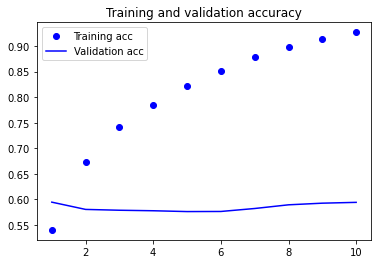

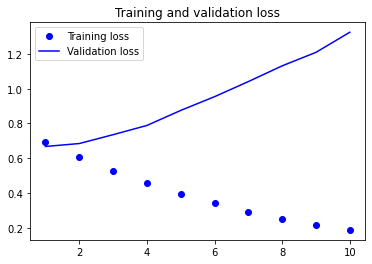

In [37]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']

val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.savefig("data/lstmacc.png")

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("data/lstmloss.png")
plt.show()

In [39]:
model_structure=model.to_json()
with open('data/char_lstm_model.json','w') as f:
    f.write(model_structure)
model.save_weights('data/char_lstm_weigths.h5')